# Manually Implemented FF Neural Networks
***
**Name**: Nicholas Renninger
***

## Goal

The goal of this assignment is to build a one-hidden-layer back propagation network to process real data.  For this assignment you will implement the neural net (activation function and training code) yourself, not using tensorflow or other deep learning frameworks. The purpose is for you to understand the nitty gritty of what these frameworks are doing for you before we switch over to using them.

## Data 
***

In this assignment you will be using the Occupancy Detection data set (ODD). It consists of experimental data used for binary classification of room occupancy (i.e., room is occupied versus empty) based on temperature, humidity, light, and CO2 sensors. The train and test data sets are each collected over a week period.

The data set includes time stamps with date and hour/minute/second within the day. You are **not to use time stamp features** for predicting occupancy. Since this is a commercial office building, the time stamp is a strong predictor of occupancy. Rather, the goal is to determine whether occupancy - **occ** can be sensed from:
1. temperature, expressed in degrees Celsius - **temp**
2. relative humidity, expressed as a % - **hum**
3. light, in lux - **light**
4. CO2, in ppm - **cdx**
5. humidity ratio, which is derived from the temperature and the relative humidity - **hum_ratio**

In [1]:
import numpy as np
import numpy.matlib
import numpy.linalg
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
import copy
from IPython.display import display, HTML

In [2]:
data = pd.read_csv('data/datatraining.txt')
display(data)
X_data = data[['date', 'Humidity', 'Light', 'CO2',
               'HumidityRatio', 'Temperature']].values
y_data = data['Occupancy'].values

X_train, X_test, y_train, y_test = train_test_split(X_data[:, 1:], y_data,
                                                    test_size=0.1)

# have to explicitly cast as an np.float or everything freaks out
X_train = np.array(X_train, dtype=np.float)
X_test = np.array(X_test, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
y_test = np.array(y_test, dtype=np.float)

# input normalization to prevent input saturation
normalize(X_train)
normalize(X_test)

# make y a column vector
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


### 1. Perceptron
***

Using the perceptron code you wrote for Assignment 1, train a perceptron (linear activation function with a binary threshold) using the training set. Your perceptron should have the 5 input variables described above.

**Part A**: Report the training and test set performance in terms of % examples classified correctly after 100 epochs.

**NOTE**: The Perceptron Update Rule is guaranteed to converge only if there is a setting of the weights that will classify the training set perfectly.  (The learning rule minimizes mistakes. When all examples are classified correctly, the weights stop changing.)  With a noisy data set like this one, the algorithm may not terminate.  Also remember that the perceptron algorithm is performing stochastic gradient descent. Thus, it will jitter around the ideal solution continually changing the weights from one iteration to the next. The weight changes will have a small effect on performance, so you'll see training set performance jitter a bit as well.

In [3]:
def perceptron_update(X, y, w, alpha):
    """
    One epoch of Perceptron updates (full sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    alpha : Learning rate
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    incorrect : Incorrectly classified examples
                (tuple of features, predicted label)
    accuracy: ratio of correctly classified to total examples
    """
    
    N = len(y)
    numberClassifiedRight = N
    incorrect = []
    
    for i in range(N):
        
        curr_x = X[i, :].reshape((-1, 1))
        curr_y = y[i]
        y_predicted = np.sign(w.T @ curr_x)
        
        # use perceptron update rule
        if curr_y != y_predicted:
            
            w = np.add(w, alpha * curr_y * curr_x)

            numberClassifiedRight -= 1
            incorrect.append((curr_x, y_predicted))
        
    accuracy = numberClassifiedRight / N

    return w, incorrect, accuracy

def perceptron(X, y, maxIter, alpha):
    """
    Implements the Perceptron algorithm.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : The maximum number of iterations allowed 
    alpha : Learning Rate
    
    Returns
    -------
    w : Coefficients of the classifier
    incorrect : Incorrectly classified examples on termination
    accuracyPerEpoch : array-like of best accuracy each epoch
    """
    
    # as we want to learn the bias term as well, need to augment our feature
    # matrix
    X_b = getFeaturesWithBias(X)

    N = len(y)
    numFeatures = X_b.shape[1]

    # initialize gradient descent with weights all being 0
    w = np.zeros((numFeatures, 1))
    numEpochs = 0
    accuracyPerEpoch = []
    maxAccuracy = 0
    best_weights = w
    while (numEpochs < maxIter):

        w, incorrect, accuracy = perceptron_update(X_b, y, w, alpha)
        accuracyPerEpoch.append(accuracy)
        
        if accuracy > maxAccuracy:
            maxAccuracy = accuracy
            best_weights = copy.deepcopy(w)

        maxAccuracy = accuracy
        if accuracy == 1:
            break
        
       # slow down printing of loss
        if (numEpochs % 10) == 0:
            print('Epoch: ', numEpochs, 'accuracy: ', accuracy)
        
        numEpochs += 1
    
    print('Max Epochs: ', numEpochs, 'Max Accuracy: ', maxAccuracy)
        
    return best_weights, incorrect, accuracyPerEpoch

def getFeaturesWithBias(X):
    """
    Returns the Feature Matrix with a column of ones added for the bias term
    
    need to add a column of ones to the feature matrix to account for the
    bias term 'b' in our linear model:
            y = w_1 * x_1 + w_2 * x_2 + b
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    
    Returns
    -------
    X_b : NumPy array of features with bias column added 
          (size : no of examples X (features + 1))
          
    Examples
    --------
    X = [[0.3 0.5]
         [0.5 0.4]
         [0.7 1.5]]
         
         
    X_b = [[0.3 0.5 1.0]
           [0.5 0.4 1.0]
           [0.7 1.5 1.0]]
    """
    
    numFeatures, _ = np.shape(X)
    biasFeatureMat = np.ones(shape=(numFeatures, 1))
    X_b = np.concatenate((X, biasFeatureMat), axis=1)
    
    return X_b

# need negative classes to be -1
y_perceptron_train = [-1 if label == 0 else 1 for label in y_train]
y_perceptron_test = [-1 if label == 0 else 1 for label in y_test]

(weights,
 incorrect,
 accuracyPerEpoch) = perceptron(X_train, y_perceptron_train, 100,
                                alpha=0.001)

print("Perceptron weight vector:", weights)
print("Number of incorrectly classified examples:", len(incorrect))

Epoch:  0 accuracy:  0.8732259825327511
Epoch:  10 accuracy:  0.9506004366812227
Epoch:  20 accuracy:  0.9596069868995634
Epoch:  30 accuracy:  0.962882096069869
Epoch:  40 accuracy:  0.9639737991266376
Epoch:  50 accuracy:  0.9635644104803494
Epoch:  60 accuracy:  0.9668395196506551
Epoch:  70 accuracy:  0.9684770742358079
Epoch:  80 accuracy:  0.9667030567685589
Epoch:  90 accuracy:  0.9688864628820961
Max Epochs:  100 Max Accuracy:  0.9692958515283843
Perceptron weight vector: [[-1.61340635e+01]
 [ 2.32450000e+00]
 [ 1.91406667e+00]
 [-4.09644288e-03]
 [-6.93185510e+01]
 [-2.89000000e+00]]
Number of incorrectly classified examples: 225


The test vs. training set performances are shown below. Very good generalization :)

In [4]:
def classify(X, y, w):
    """
    Use this function to classify examples in the test set
    
    Parameters
    ----------
    X : Test set features
    y : Test set labels
    w : Perceptron coefficients
    
    Returns
    -------
    accuracy: ratio of correctly classified to total examples
    """
    
    N = len(y)
    numberClassifiedRight = N
    
    # as we want to learn the bias term as well, need to augment our feature
    # matrix
    X_b = getFeaturesWithBias(X)
    
    for i in range(N):
        
        curr_x = X_b[i, :].reshape((-1, 1))
        curr_y = y[i]

        y_predicted = np.sign(w.T @ curr_x)
        if curr_y != y_predicted:
            numberClassifiedRight -= 1

    accuracy = numberClassifiedRight / N
    
    return accuracy

# testing the perceptron
train_accuracy = classify(X_train, y_perceptron_train, weights)
test_accuracy = classify(X_test, y_perceptron_test, weights)

print('train accuracy:', train_accuracy)
print('test accuracy:', test_accuracy)

train accuracy: 0.9705240174672489
test accuracy: 0.9668711656441717


### 2. 1-layer feedforward neural net
***

In this part, you will implement a 1-layer feedforward neural network from scratch as shown in the figure below.
<img src="./res/mlp_ann.png" alt="mlp_ann" style="width:500px;"/>
Your tasks are as follows:

**PART 2.A**

1. Implement `sigmoid(x)`: In this assignment, we will be using the sigmoid activation function as the non-linearity.
2. Implement `forward(x)` which calculates the activations at layer 1, 2 and 3 (stored in variables `_a01`, `_a12`, `_a23` respectively) and returns the final layer activations.
3. Implement `backward(y, y_hat)` such that it returns layer 1 and layer 2 gradients using the mean squared loss between the predicted and groundtruth vectors.
4. Implement `update(l1_grad, l2_grad)` function which will update the weights and biases stored in `_W1, _W2 and _b1, _b2`.
5. Implement`train(X, y, epochs)`.
6. Implement `predict(X)` to return one-hot encoded representation of the `_a23` layer activation.

In [5]:
rndg = np.random.RandomState(seed=0)

class MLP(object):
    """
        -- Multi-Layer Perceptron Neural Net.
           Network has 1 input layer followed by a hidden layer and
           an output layer. 
    """
    def __init__(self, n_vis=5, n_hid=10, n_out=1, batch_size=7, lr=0.1):
        """
            Initialize an MLP object.
            
            params
            
            n_vis (int): # of neurons in input layer.
            n_hid (int): # of neurons in hidden layer.
            n_out (int): # number of neurons in final output layer.
            batch_size (int): # number of X,y instances in a mini-batch.
            lr (double): learning rate/step size.

            class variables:
            
            _W1, _b1 (np.ndarray): 
                Weights and biases of the input layer respectively.
            
            _W2, _b2 (np.ndarray):
                Weights and biases of the hidden layer respectively.
            
            _a01, _a12, _a23 (np.ndarray or None):
                Activations from input, hidden and output layer respectively. 
                
            _l1_grad_b1, _l2_grad_b2 (np.ndarray or None):
                Gradients of the loss w.r.t. the biases. 
        """
        self._n_vis = n_vis
        self._n_hid = n_hid
        self._n_out = n_out
        
        self._W1 = rndg.normal(size=(self._n_hid, self._n_vis))
        self._b1 = np.ones((self._n_hid, 1))

        self._W2 = rndg.normal(size=(self._n_out, self._n_hid))
        self._b2 = np.ones((self._n_out, 1))

        self._a01 = None
        self._a12 = None
        self._a23 = None
        
        self._l1_grad_b1 = None
        self._l2_grad_b2 = None
        
        self.batch_size = batch_size
        self.lr = lr

    def sigmoid(self, X):
        """
            Sigmoid Logistic Function.
            
            params:
            
            X (np.ndarray)
            
            return:
            
            result (np.ndarray): result = f(X) 
                where f is the sigmoid function.
            
        """

        return 1.0 / (1.0 + numpy.exp(-X)) 
    
    def sigmoid_gradient(self, X):
        """
            Gradient of the Sigmoid Logistic Function.
            
            params:
            
            X (np.ndarray)
            
            return:
            
            result (np.ndarray): result = ∇f(X) 
                where ∇f is the gradient of the sigmoid function.
            
        """
        
        # want to use element-wise (hadamard) product to ensure proper gradient
        # calculation
        gradient = self.sigmoid(X) * (1.0 - self.sigmoid(X))

        return gradient
    
    def compute_MSE_loss(self, y, y_hat):
        """
        Computes the total MSE loss for across all y-y_hat pairs

        Parameters
        ----------
        y : Numpy array of output value 'y' (size : no of examples X 1)
        y_hat : Numpy array of estimated output value 
                (size : no of examples X 1)

        Returns
        -------
        loss : scalar MSE loss over the whole data set
        """

        N = len(y)
        residuals = (y - y_hat) ** 2
        loss = 1 / (2 * N) * np.sum(residuals)

        return loss
    
    def compute_MSE_loss_gradient(self, y, y_hat):
        """
        Computes the total MSE loss gradient w.r.t. y_hat across all y-y_hat
        pairs

        Parameters
        ----------
        y : Numpy array of output value 'y' (size : no of examples X 1)
        y_hat : Numpy array of estimated output value
                (size : no of examples X 1)

        Returns
        -------
        loss_gradient : array of MSE loss gradient over the whole data set
        """

        N = len(y)
        loss_gradient = (y.flatten() - y_hat.flatten())
        loss_gradient = loss_gradient.reshape((N, 1))
        
        return loss_gradient

    def forward(self, X):
        """
            Feed forward an input through each 
            of the layers of network.
            
            Store each layer activation in the class 
            variables defined in the constructor. You'll
            need them later during backpropogation.
            
            params:
            
            X (np.ndarray): batch_size x 5 dimensional array
            
            return:
            
            y_hat (np.ndarray): 1 x batch_size dimensional array
                representing final layer outputs.
            
        """
        
        self._a01 = X

        batch_size = len(X)
        b1_biases = np.matlib.repmat(self._b1.T, batch_size, 1)
        b2_biases = np.matlib.repmat(self._b2.T, batch_size, 1)

        self._a12 = self.sigmoid(self._a01 @ self._W1.T + b1_biases)
        self._a23 = self.sigmoid(self._a12 @ self._W2.T + b2_biases)
        
        return self._a23

    def backward(self, y, y_hat):
        """
        Implement the backpropogation algorithm.
        Assume mean squared loss at the output.
        calculate and update gradients of the loss w.r.t. the biases

        params:

        y (np.ndarray): batch_size x 1 dimensional vector
            of grounf truth labels.
        y_hat (np.nd_array): 1 x batch_size dimensional vector
            of predicted lables from forward().

        return:

        W1_grad (np.ndarray): n_hid x n_vis dimensional array
            representing gradients for hidden layer. 
            (gradients of the loss w.r.t. the _W1)

        W2_grad (np.ndarray): 1 x n_hid dimensional array
            representing gradients for input layer. 
            (gradients of the loss w.r.t. the _W2)
        """

        # gradient w.r.t. output activations
        output_loss = self.compute_MSE_loss_gradient(y, y_hat)
        grad_output_activ = output_loss * self.sigmoid_gradient(y_hat)
                            
        # gradient w.r.t. hidden layer biases
        _, numOutputs = grad_output_activ.shape
        self._l2_grad_b2 = np.reshape(np.mean(grad_output_activ, axis=0),
                                      (numOutputs, 1))
        
        # gradient w.r.t. hidden layer weights
        hidden_layer_values = self._a12
        W2_grad = np.dot(grad_output_activ.T, hidden_layer_values)
        
        # gradient w.r.t. hidden layer values
        grad_hidden = np.dot(self._W2.T, grad_output_activ.T)
        
        # gradient w.r.t. hidden layer output activations
        grad_hidden_activ = grad_hidden * \
                            self.sigmoid_gradient(hidden_layer_values).T
        
        # gradient w.r.t. hidden layer biases
        numHidden, _ = grad_hidden_activ.shape
        self._l1_grad_b1 = np.reshape(np.mean(grad_hidden_activ, axis=1),
                                      (numHidden, 1))
        
        # gradient w.r.t. input layer weights
        input_layer_values = self._a01
        W1_grad = np.dot(grad_hidden_activ, input_layer_values)
        
        return W1_grad, W2_grad
        
    def update(self, l1_grad, l2_grad):
        """
            Implement the update rule for network weights and biases.
            
            params:
            
            l1_grad (np.ndarray): gradients for input layer.
            l2_grad (np.ndarray): gradients for hidden layer.
            
            return:
            
            none.
        """
        
        # weight matrix updates
        self._W1 += self.lr * l1_grad
        self._W2 += self.lr * l2_grad
        
        # bias vector updates
        self._b1 += self.lr * self._l1_grad_b1
        self._b2 += self.lr * self._l2_grad_b2
        
    def predict(self, X, threshold = 0.5):
        """
        Returns one hot encoding of vector X using 0.5
        as the default threshold.

        params:

        X (np.ndarray): N x 5 dimensional ndarray of inputs.

        return:

        y (np.ndarray): one hot encoding of output layer.
        """
        
        y_hat = self.forward(X)
        y_hat_labels = [0 if value <= threshold else 1 for value in y_hat]
        
        y_hat_labels = np.array(y_hat_labels)
        
        return y_hat_labels
    
    def get_batch_indices(self, curr_idx, batch_size, num_batches,
                          batch_remainder):
        """
        Calculates the mini-batch indices in the larger data set

        Parameters
        ----------
        curr_idx : the batch index
        batch_size : the number of examples in each batch
        num_batches : the number of batches to split the total epoch into
        batch_remainder : the number of batches that don't fit into
                          num_batches groups of size batch_size in the full
                          dataset

        Returns
        ----------
        a list of indices into the main data set to use in the current batch
        """

        startIdx = curr_idx * batch_size
        endIdx = (curr_idx + 1) * batch_size

        # may need to make the last batch extra big to handle spillover
        makeLastBatchBigger = False
        if batch_remainder != 0:
            makeLastBatchBigger = True

        atLastBatch = curr_idx == (num_batches - 1)
        if atLastBatch and makeLastBatchBigger:
            endIdx += batch_remainder

        batchIndices = range(startIdx, endIdx)

        return batchIndices
    
    def mini_batch_update(self, X, y):
        """
        One epoch of mini-batch SGD over the entire dataset (i.e. one sweep of
        the dataset).

        Parameters
        ----------
        X : NumPy array of features (size : no of examples X features)
        y : Numpy array of class labels (size : no of examples X 1)

        Returns
        -------
        loss after epoch
        """

        N = len(y)
        if self.batch_size > N:
            msg = 'batch size: ' + str(self.batch_size) + \
                  ' cannot be larger than' + \
                  ' the number of examples: ' + str(N)
            raise ValueError(msg)
            
        numBatches, remainder = divmod(N, self.batch_size)

        for i in range(numBatches):

            # need to shuffle the features each epoch for SGD
            X, y = shuffle(X, y)
            batchIndices = self.get_batch_indices(i, self.batch_size,
                                                  numBatches, remainder)
            features = X[batchIndices, :]
            targets = y[batchIndices]
            
            # run forward sweep of network to calculate new network
            # prediction for loss calculation in grad descent
            y_hat = self.forward(X=features)
            
            # calculate weight gradients using backprop
            l1_grad, l2_grad = self.backward(y=targets, y_hat=y_hat)
            
            # perform the gradient descent update step using the new weight
            # matrices and the bias gradients (why are these private class 
            # instance variables? who knows.)
            self.update(l1_grad, l2_grad)

        return self.compute_MSE_loss(y, self.forward(X))

    def train(self, X, y, maxEpochs, X_test=None, y_test=None):
        """
        Implement the train loop for n epochs.
        In each epoch do the following:
        1. Shuffle the dataset.
        2. create self.batch_size sized-mini-batches of the dataset.
        3. get network predictions using forward().
        4. calculate the gradients using backward().
        5. update the network weights using update().
        6. Repeat 1-5 until convergence.

        params:

        X (np.ndarray): N x 5 dimensional ndarray of inputs.
        y (np.ndarray): N x 1 dimensional array of true labels.
        maxEpochs (int): # of epochs to train the network for.
        
        optional
        X_test (np.ndarray): N x 5 dimensional ndarray of test inputs.
        y_test (np.ndarray): N x 1 dimensional array of true test labels.

        return:

        list of final MSE losses after each epoch,
        list of final test accuracies after each epoch on the data
        (defaults to training accuracy, will use test if present)
        """
        
        if (X_test is not None) and (y_test is not None):
            computeAccuraciesWithTestData = True
        else:
            computeAccuraciesWithTestData = False
        
        # define a loss tolerance as an additional termination condition
        lossRelTol = 1e-6
        loss = np.inf
        lossRelDiff = np.inf

        # the only difference between SGD, mini-batch, and full batch grad
        # descent is batch sizes
        N = len(y)

        # initialize gradient descent with weights all being 0
        numFeatures = X.shape[1]
        w = np.zeros((numFeatures, 1))
        numEpochs = 0
        lossPerEpoch = []
        accuracyPerEpoch = []
        while (numEpochs < maxEpochs) and (lossRelDiff > lossRelTol):

            newLoss = self.mini_batch_update(X, y)
            
            # compute new model accuracy on the desired data set
            if computeAccuraciesWithTestData:
                X_acc = X_test
                y_acc = y_test
            else:
                X_acc = X
                y_acc = y

            y_hat = self.predict(X_acc)
            currAccuracy = self.accuracy(y_acc, y_hat)
            accuracyPerEpoch.append(currAccuracy)
            
            # compute relative loss improvement
            lossRelDiff = np.abs(loss - newLoss)
            loss = newLoss
            lossPerEpoch.append(loss)

            # slow down printing of loss
            if (numEpochs % 10) == 0:
                print('Epoch: ', numEpochs, 'Loss: ', loss)

            numEpochs += 1

        print('Max Epochs: ', numEpochs,
              'Final Loss: ', loss,
              'Final Accuracy: ', currAccuracy)

        return lossPerEpoch, accuracyPerEpoch
            
    def test(self, X_test, y_test):
        """
        Implement the test function which reports accuracy of 
        the model on the test set X_test against the true labels
        y_test.

        You may re-use the predict and accuracy functions defined above.

        params:

        X_test (np.ndarray): N x M dimensional array where M is the 
            number of attributes considered for training the model.
        y_test (np.ndarray): N x 1 dimensional array.

        return:

        accuracy (double): accuracy of the predicted labels against the 
            groundtruth labels.
        """

        y_hat = self.predict(X_test)

        return self.accuracy(y_test, y_hat)
    
    @classmethod
    def accuracy(self, y, y_hat):
        numFeatures = y.flatten().shape[0]
        return np.sum(y.flatten() == y_hat.flatten()) / numFeatures

In [6]:
import unittest
from sklearn.datasets import make_classification

def load_params(path, model):
    
    params = pickle.load(open(path, 'rb'))
    for key in params:
        model.__dict__[key] = params[key]

class TestMLP(unittest.TestCase):
    def setUp(self):
        
        self.net = MLP()
        self.pre_trained_model = load_params("./res/mlp.pkl", self.net)
        self.X = np.load("./res/x.npy")
        self.y = np.load("./res/y.npy")
        self.p = np.load("./res/p.npy")
        self.sigX = np.asarray([-1, -2, -3, 0, 1, 2, 3])
    
    def test_forward(self):
        self.assertEqual(np.sum(self.net.forward(self.X[901:])),
                         np.sum(self.p))
    
    def test_train(self):
        x, y = make_classification(
            n_samples=1000,
            n_features=5,
            n_redundant=0,
            random_state=rndg
        )
        net = MLP(5, 5, 1, 7, 0.01)
        net.train(self.X[:900], self.y[:900], 100)
        testAccuracy = net.test(self.X[901:], self.y[901:])
        print('test accuracy:', testAccuracy)
        self.assertTrue(testAccuracy > 0.88)
    
    def test_sigmoid(self):
        self.assertEqual(
            np.sum(self.net.sigmoid(self.sigX)), 3.5
        )

suite = unittest.TestLoader().loadTestsFromTestCase(TestMLP)
unittest.TextTestRunner().run(suite)

..

Epoch:  0 Loss:  124.25668927614994
Epoch:  10 Loss:  163.94059403718654
Epoch:  20 Loss:  185.69492265634656
Epoch:  30 Loss:  194.50938824361876
Epoch:  40 Loss:  200.816372355032
Epoch:  50 Loss:  203.87722061671494
Epoch:  60 Loss:  205.96541551539028
Epoch:  70 Loss:  207.86155615388662
Epoch:  80 Loss:  208.58179585293536
Epoch:  90 Loss:  209.66291914113333


.

Max Epochs:  100 Final Loss:  210.57521395198535 Final Accuracy:  0.9722222222222222
test accuracy: 0.98989898989899



----------------------------------------------------------------------
Ran 3 tests in 2.861s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

**PART 2.B**

Report the baseline performance of the untrained MLP that you built in **PART 2.A** using the selected values. To calculate the baseline score, feed-forward entire test set through the test function. The test function will return a set of predictions. Calculate the accuracy of these predictions against ground truth training lables.  
Report:
1. accuracy

In [7]:
classifier = MLP()
baselineAccuracy = classifier.test(X_test, y_test)
print("Baseline accuracy:", baselineAccuracy)

Baseline accuracy: 0.2282208588957055


<ipython-input-5-71db5e83db0b>:70: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + numpy.exp(-X))


**PART 2.C**

Select a learning rate, batch size and train the network for 100 epochs. Plot a graph of network's accuracy on the test data as a function of epoch. On the same graph, plot a constant horizontal line of the baseline score that you reported in **PART 2.B**.  

Report:
1. learning rate
2. batch size

<ipython-input-5-71db5e83db0b>:70: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + numpy.exp(-X))


Epoch:  0 Loss:  0.09091494403281337
Epoch:  10 Loss:  0.05559586651787933
Epoch:  20 Loss:  0.05457309168636241
Epoch:  30 Loss:  0.050886934889714124
Epoch:  40 Loss:  0.04897280252384355
Epoch:  50 Loss:  0.053442987510561736
Epoch:  60 Loss:  0.04813847408723067
Epoch:  70 Loss:  0.04667221881818712
Epoch:  80 Loss:  0.0447754963760889
Epoch:  90 Loss:  0.04545053882181078
Epoch:  100 Loss:  0.044850600549507305
Epoch:  110 Loss:  0.04522285014536697
Epoch:  120 Loss:  0.042830305300392814
Epoch:  130 Loss:  0.04235386432467418
Epoch:  140 Loss:  0.04168627240357401
Epoch:  150 Loss:  0.03958953223922048
Epoch:  160 Loss:  0.0389074970020256
Epoch:  170 Loss:  0.039071417570832115
Epoch:  180 Loss:  0.03843851745254349
Epoch:  190 Loss:  0.038113453074655544
Max Epochs:  200 Final Loss:  0.037217031597840906 Final Accuracy:  0.90920245398773


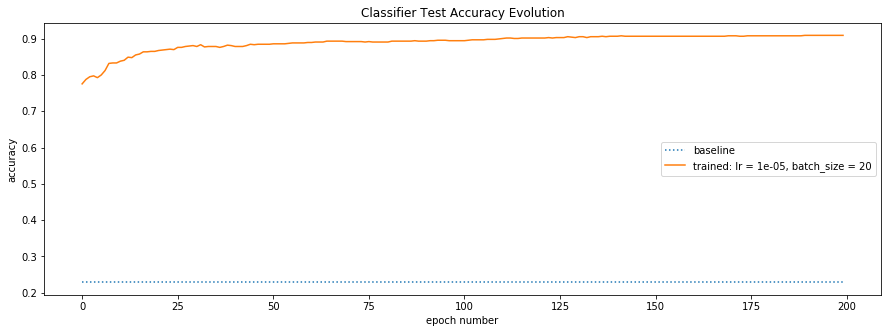

In [14]:
def plot_loss(indices, lossData, xlabel, ylabel, **kwargs):
    
    plt.figure()
    
    # make it wide to see the timeseries more easily
    plt.rcParams['figure.figsize'] = [15, 5]
    
    if 'baseline' in kwargs:
        baseline = kwargs['baseline']
        plt.plot(indices, np.ones(len(indices)) * baseline, ':')
    
    for loss in lossData:
        plt.plot(indices, loss, '-')
    
    if 'title' in kwargs:
        plt.title(kwargs['title'])
    else:
        plt.title('Linear Regression MSE Loss')
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
    if 'legendStrings' in kwargs:
        plt.legend(kwargs['legendStrings'])

lr = 0.00001
batch_size = 20
classifier = MLP(batch_size=batch_size, lr=lr)
maxEpochs = 200
loss, accuracyPerEpoch = classifier.train(X_train, y_train,
                                          maxEpochs=maxEpochs,
                                          X_test=X_test,
                                          y_test=y_test)       

test_epoch_indices = range(0, len(accuracyPerEpoch))
plot_loss(test_epoch_indices, [accuracyPerEpoch[0:maxEpochs]],
          xlabel='epoch number',
          ylabel='accuracy',
          title='Classifier Test Accuracy Evolution',
          baseline=baselineAccuracy,
          legendStrings=('baseline',
                         'trained: lr = %0.3g, batch_size = %d' % (lr,
                          batch_size)))

**PART 2.D**

Now train nets with varying size of the hidden layer $H={1, 2, 5, 10..}$ for max epochs = 100. Make a plot of the nets' accuracy on test set as a function of $H$.

<ipython-input-5-71db5e83db0b>:70: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + numpy.exp(-X))


Epoch:  0 Loss:  0.2185865483566485
Epoch:  10 Loss:  0.21810079392080664
Epoch:  20 Loss:  0.21767546203793797
Epoch:  30 Loss:  0.21724958860300456
Epoch:  40 Loss:  0.21682241141186945
Epoch:  50 Loss:  0.2163992529307883
Epoch:  60 Loss:  0.2159741298431692
Epoch:  70 Loss:  0.21555035532838027
Epoch:  80 Loss:  0.2151272726384951
Epoch:  90 Loss:  0.21470278498586243
Max Epochs:  100 Final Loss:  0.2143210540917173 Final Accuracy:  0.2105622270742358
Test set accuracy for n_hid=1: 0.22822
Epoch:  0 Loss:  0.21852091092025708
Epoch:  10 Loss:  0.21809541131552887
Epoch:  20 Loss:  0.21766729328902126
Epoch:  30 Loss:  0.21724300468559396
Epoch:  40 Loss:  0.21681803745725745
Epoch:  50 Loss:  0.21639309583554356
Epoch:  60 Loss:  0.21596738252618217
Epoch:  70 Loss:  0.21554165599938885
Epoch:  80 Loss:  0.21511597508030397
Epoch:  90 Loss:  0.21469153857849482
Max Epochs:  100 Final Loss:  0.2143120126292842 Final Accuracy:  0.2105622270742358
Test set accuracy for n_hid=2: 0.2282

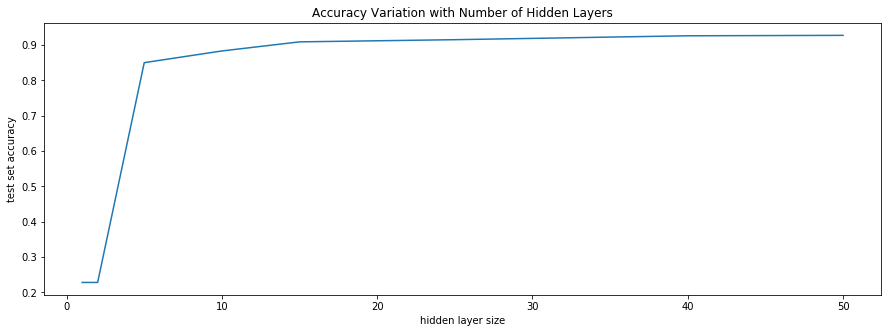

In [9]:
hidden_layer_sizes = [1, 2, 5, 10, 15, 25, 40, 50]
lr = 0.00001
batch_size = 20
maxEpochs = 100

accuracies = []
for hidden_layer_size in hidden_layer_sizes:
    
    classifier = MLP(n_hid=hidden_layer_size, batch_size=batch_size, lr=lr)
    classifier.train(X_train, y_train, maxEpochs=maxEpochs)
    
    currAccuracy = classifier.test(X_test, y_test)
    accuracies.append(currAccuracy)
    
    print('Test set accuracy for n_hid=%d: %0.5g' %
          (hidden_layer_size, currAccuracy))

plot_loss(hidden_layer_sizes, [accuracies],
          xlabel='hidden layer size',
          ylabel='test set accuracy',
          title='Accuracy Variation with Number of Hidden Layers')

### 3. Extra Credit

See how much adding information about time of day helps the network. Add a new set of inputs that represent the time of day. (Don't add information about day of week or absolute date.)  


**PART 3.A**  

Determine an appropriate representation for the time of day. Describe the representation you used. For example, you might add one unit with a value ranging from 0 to 1 for times ranging from 00:00 to 23:59. Report the representation you selected.


In [10]:
### Part 3.A

**PART 3.B**  

Train your net with $H=5$ hidden and compare training and test set performance to the net you built in (2c)

In [11]:
### Part 3.B